In [2]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from multiprocessing import Pool
from glob import glob

In [3]:
def get_width(A):
    """
    Get width for every x-value.

    Parameters
    ----------
    A : ndarray
        array of shape n x 3 with cols: 'X','Y','Z'

    Returns
    -------
    ux : ndarray
        all unique x 
    w : ndarray
        widths of each profile
    """

    # get unique x values
    ux = np.unique(A[:,0])

    # get width at each slice
    s = pd.Series(A[:, 1])
    ymin = s.groupby(A[:, 0]).min()
    ymax = s.groupby(A[:, 0]).max()
    w = np.array((ymax - ymin).dropna())

    return ux, w

In [4]:
def get_height(A0,A1):
    """
    Get height between two layers for every slice.

    Parameters
    ----------
    A0 : ndarray
        lower layer array of shape n x 3 with cols: 'X','Y','Z'
    A1 : ndarray
        upper layer array of shape n x 3 with cols: 'X','Y','Z'

    Returns
    -------
    ux : ndarray
        all unique x 
    h : ndarray
        true height of new layer
    """

    # get unique x values that are in both layers
    ux0 = np.unique(A0[:,0])
    ux1 = np.unique(A1[:,0])
    ux = np.intersect1d(ux0,ux1)

    # get height at each slice
    s0 = pd.Series(A0[:, 2])
    s1 = pd.Series(A1[:, 2])
    z_max0 = s0.groupby(A0[:, 0]).max()
    z_max1 = s1.groupby(A1[:, 0]).max()
    h = np.array((z_max1 - z_max0).dropna()) # NaN where ux is not both arrays
    
    return ux, h

In [5]:
def get_shift(arr0,arr1):
    """
    Get shift of weld bead top (y-Direction).

    Parameters
    ----------
    arr0 : ndarray
        lower layer array of shape n x 3 with cols: 'X','Y','Z'
    arr1 : ndarray
        upper layer array of shape n x 3 with cols: 'X','Y','Z'

    Returns
    -------
    s : ndarray
        shift of weld bead top in y-direction
    """

    # get shift at each ux
    df0 = pd.DataFrame(arr0)
    df1 = pd.DataFrame(arr1)
    
    # Find the indices of the maximum values in the third column for each x-value
    m0 = df0.groupby(0)[2].idxmax()
    m1 = df1.groupby(0)[2].idxmax()

    # Extract the corresponding values from the first and second column using the indices
    x0,y0 = df0.loc[m0, 0], df0.loc[m0, 1]
    x1,y1 = df1.loc[m1, 0], df1.loc[m1, 1]

    # get shift of weld bead top in y-direction
    y0.index = x0 # set index to x-values, otherwise y1-y0 = NaN because indices don't agree
    y1.index = x1
    s = np.array((y1 - y0).dropna()) # shift of new layer compared to previous layer

    # # scatter plot 3D
    # from mpl_toolkits.mplot3d import Axes3D
    # fig = plt.figure(figsize=(4.24*1.5,3*1.5))
    # ax = fig.add_subplot(111, projection='3d')
    # ax.scatter(x1,y1,z1)
    # ax.set_xlabel('x [mm]')
    # ax.set_ylabel('y [mm]')
    # ax.set_zlabel('z [mm]')
    # plt.show()

    return s

In [6]:
def get_medians(npy_list,xMin,xMax):
    """
    Get median width, height and shift for each layer

    Parameters
    ----------
    npy_list : list
        list of numpy arrays with cols: 'X','Y','Z'
    xMin: float
        start of analysis area
        use x-z-plot to set limits
    xMax: float
        end of analysis area

    Returns
    -------
    w : ndarray
        median width of each layer
    h : ndarray
        median height of each layer
    s : ndarray
        median shift of each layer
        """

    # make empty lists for values
    w = []
    h = []
    s = []

    for i,arr1 in enumerate(npy_list):
        if i==0: continue # omit layer_00
        else:
            # get lower layer data
            arr0 = npy_list[i-1]

            # crop data in x-direction
            arr0 = arr0[(arr0[:,0]>xMin) & (arr0[:,0]<xMax)] # lower layer
            arr1 = arr1[(arr1[:,0]>xMin) & (arr1[:,0]<xMax)] # upper layer

            # get width & height of every scan
            ux,width = get_width(arr1)
            ux,height = get_height(arr0,arr1)
            shift = get_shift(arr0,arr1)

            # get median width & height
            median_w,median_h,median_s = np.median(width), np.median(height),np.median(shift)

            # append median to list
            w.append(median_w)
            h.append(median_h)
            s.append(median_s)

    # shift of first layer is always 0
    s[0] = 0

    w = np.array(w)
    h = np.array(h)
    s = np.array(s)

    return w,h,s

In [7]:
def plot_all_layers_2D(arr_list,data_dir,x):
    """
    Plot all layers in one plot. In 2D.

    Parameters
    ----------
    arr_list : list of numpy arrays
        list of shape (N,) and arrays of shape (n,3)
        point cloud of isolated weld surfaces
    data_dir: string
        folder path for saving figure
    x : float
        x value at cross-section

    Returns
    -------
    None --> Creates plot
    """

    # get number of arrays
    N = len(arr_list)

    # create a new colormap with 15 colors based on tab20
    cmap = plt.get_cmap('tab20c')
    new_cmap = ListedColormap(cmap(np.linspace(0, 1, N)))

    # Concatenate the arrays
    concatenated_array = np.concatenate(arr_list)

    # Add a fourth column with the array index
    indices = np.concatenate([np.full((arr.shape[0], 1), i) for i, arr in enumerate(arr_list)], 
                             axis=0)
    concatenated_array = np.hstack((concatenated_array, indices))

    # Plotting the scatter plot
    fig, ax = plt.subplots(figsize=[4.24,3*1.5])
    scatter_plot = ax.scatter(concatenated_array[:, 1], concatenated_array[:, 2], 
                            c=concatenated_array[:, 3], cmap=new_cmap, marker='.')

    # make custom colorbar
    cbar = plt.colorbar(scatter_plot)
    cbar.set_label('Layer', rotation=270, labelpad=15)
    cbar.set_ticks(np.arange(0, N)*(N-1)/N+0.5)
    cbar.set_ticklabels(np.arange(0, N)+1)
    
    # setup figure
    ax.set_xlabel('Y [mm]')
    ax.set_ylabel('Z [mm]')
    ax.axis('equal')
    # ax.set_ylim(bottom=0,top=35)
    # ax.set_xlim(left=-10,right=10)

    plt.show()
    fig.savefig(str(data_dir[-3:]+'_cross-section_x='+str(x)+'.svg'), format='svg')

# load data

In [8]:
if __name__ ==  '__main__': 
    # get time for performance monitoring
    t0 = time.time()

    # load all scans of a one specimen
    data_dir = r"C:\Users\mie\Documents\GIT_Repositories\scan_analyze\data\V07"
    npy_files = glob(os.path.join(data_dir, "layer***.npy"))
    with Pool(processes=len(npy_files)) as pool:
        arr_list = pool.map(np.load, npy_files)
    
    # time
    print('read finished after: ' + str(np.round(time.time()-t0, 1)) + ' s')

read finished after: 1.6 s


In [9]:
# To do:
# 1. analyze influence between Q, mass input, layer width and layer height
# make pareto diagramm in python --> Minitab!

# plot x-z-graph of all layers

In [ ]:
# create figure
fig,ax = plt.figure(figsize=(4.24*2,3*1.0)),plt.subplot(111)

# create a new colormap with 15 colors based on tab20
cmap = plt.get_cmap('tab20c')
new_cmap = ListedColormap(cmap(np.linspace(0, 1, len(arr_list[1:]))))

# initialize lists
ux_list,max_z_list,index_list=[],[],[]

for index, A in enumerate(arr_list[1:]):
    # get unique x values
    ux = np.unique(A[:,0])
    ux_list.append(ux)

    # get max z values at ux
    s = pd.Series(A[:, 2])
    max_z = s.groupby(A[:, 0]).max()
    max_z_list.append(max_z)

    # get index
    index_array = np.full((ux.shape[0], 1), index)
    index_list.append(index_array)

# Concatenate the arrays
X = np.concatenate(ux_list)
Z = np.concatenate(max_z_list)
ID = np.concatenate(index_list).flatten()
B = np.column_stack((X,Z,ID))

# plot
scatter_plot = plot = ax.scatter(X,Z,c=ID,cmap=new_cmap,marker='.')

# add custom colorbar
colorbar = plt.colorbar(plot)
colorbar.set_label('Layer', rotation=270, labelpad=15)
N = len(arr_list[1:])
colorbar.set_ticks(np.arange(0, N)*(N-1)/N+0.5)
colorbar.set_ticklabels(np.arange(0, N)+1)

# ax.axis('equal')
# ax.grid(True)
ax.set_xlabel('x [mm]')
ax.set_ylabel('z [mm]')
ax.set_xlim([-10,210])
# ax.set_ylim([0,30])
plt.show()

fig.savefig(str(data_dir[-3:] + '_z.svg'), format='svg')

# plot height and width of each layer

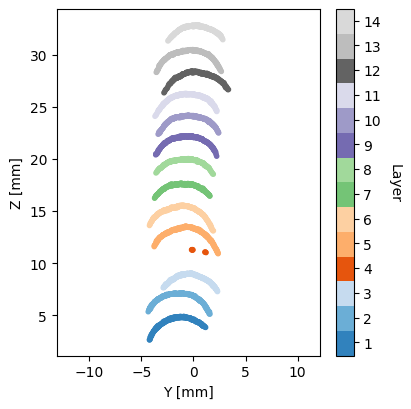

In [15]:
x = 75 # target x-value of slice
diff_threshold = 10*1e-2  # Define the threshold for considering the difference as "close"
filtered_list = []
    
for arr in arr_list[1:]:
    # Calculate the absolute difference
    diff = np.abs(arr[:, 0] - x)
    # Find the rows where the difference is within the threshold
    close_rows = arr[np.abs(diff - diff_threshold) < 1e-1]  
    filtered_list.append(close_rows)

plot_all_layers_2D(filtered_list,data_dir,x)

# V01: Zig-zag-pattern in material deposition clearly visible in layers 06-15

# get median width and height

In [16]:
w,h,s = get_medians(arr_list,xMin=50,xMax=125) # V04: 40,125

# plot height & width

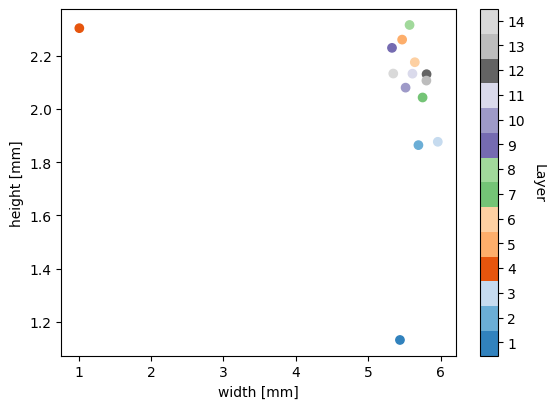

In [17]:
# scatter plot
fig = plt.figure(figsize=(4.24*1.5,3*1.5))
ax = plt.subplot(111)

# create a new colormap with 15 colors based on tab20
cmap = plt.get_cmap('tab20c')
new_cmap = ListedColormap(cmap(np.linspace(0, 1, len(w))))

# create plot
scatter_plot = ax.scatter(w,h,c=np.arange(len(w)),cmap=new_cmap,label=np.arange(len(w)))

# custom colorbar
colorbar = plt.colorbar(scatter_plot)
colorbar.set_label('Layer', rotation=270, labelpad=15)
colorbar.set_ticks(np.arange(0, len(w))*(len(w)-1)/len(w)+0.5)
colorbar.set_ticklabels(np.arange(0, len(w))+1)

# axis options
ax.set_xlabel('width [mm]')
ax.set_ylabel('height [mm]')
plt.show()

# save figure
fig.savefig(str(data_dir[-3:]+'_hw.svg'), format='svg')

# write a table with height and width
arr_save = np.vstack((h,w))
np.save(str(data_dir[-3:]+'_hw.npy'), arr_save)

# plot shift

In [18]:
# scatter plot
fig = plt.figure(figsize=(4.24*1.5,3*1.5))
ax = plt.subplot(111)

# create a new colormap with 15 colors based on tab20
cmap = plt.get_cmap('tab20c')
new_cmap = ListedColormap(cmap(np.linspace(0, 1, len(w))))

# Add horizontal lines
ax.hlines(h, s-w/2, s+w/2, colors='k', linestyles='dotted',alpha=0.1)

# Add vertical line at x=0
ax.axvline(x=0, c='k', linestyle='--')

# create plot
scatter_plot = ax.scatter(s,h,c=np.arange(len(w)),cmap=new_cmap,label=np.arange(len(w)))

# custom colorbar
colorbar = plt.colorbar(scatter_plot)
colorbar.set_label('Layer', rotation=270, labelpad=15)
colorbar.set_ticks(np.arange(0, len(w))*(len(w)-1)/len(w)+0.5)
colorbar.set_ticklabels(np.arange(0, len(w))+1)

# axis options
ax.set_xlabel('shift [mm]')
ax.set_ylabel('height [mm]')
plt.show()

# # save figure
# fig.savefig(str(data_dir[-3:]+'_hs.svg'), format='svg')